In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

import sys
sys.path.append('..')
# load utils
from src.feature_utils.io import load_many_csvs
from src.feature_utils.cleaning import clean
from src.feature_utils.aggregate import aggregate_low

# Load and process all songs

In [2]:
rows = []
ids = []
failed = 0

for sid, df in tqdm(load_many_csvs(Path("../data/raw/features"))):
    try:
        df_clean = clean(df)
        if df_clean.shape[0] < 5 or df_clean.shape[1] < 10:
            failed += 1
            continue
        agg = aggregate_low(df_clean)
        rows.append(agg)
        ids.append(sid)
    except Exception as e:
        print(f"Failed {sid}: {e}")

1802it [03:54,  7.69it/s]


In [3]:
AGG = pd.DataFrame(rows, index=ids)
print(f"Processed {len(AGG)} songs successfully, {failed} failed")
print(f"Low-level features shape: {AGG.shape}")

Processed 1802 songs successfully, 0 failed
Low-level features shape: (1802, 2080)


# Load labels and hierarchy map

In [4]:
# Load labels and set the index immediately
labels = pd.read_parquet("../data/processed/DEAM/deam_core_with_lyrics.parquet")
labels = labels.set_index('song_id')

print(f"Feature songs: {len(AGG)}")
print(f"Label songs: {len(labels)}")

Feature songs: 1802
Label songs: 1802


In [5]:
AGG.index = AGG.index.astype(int)

In [6]:
# both AGG and labels are indexed by song_id
common_ids = AGG.index.intersection(labels.index)
print(f"Common songs: {len(common_ids)}")

Common songs: 1802


In [7]:
# Align the datasets using the common_ids
AGG_aligned = AGG.loc[common_ids]
y_valence_mean = labels.loc[common_ids, 'valence_mean']
y_arousal_mean = labels.loc[common_ids, 'arousal_mean']
y_valence_std = labels.loc[common_ids, 'valence_std']
y_arousal_std = labels.loc[common_ids, 'arousal_std']

print(f"Test songs in aligned set: {(AGG_aligned.index > 2000).sum()}")

Test songs in aligned set: 58


In [8]:
print(f"Aligned dataset: {AGG_aligned.shape}")
print(f"Label statistics:")
print(f"Valence mean: {y_valence_mean.mean():.3f} ± {y_valence_mean.std():.3f}")
print(f"Arousal mean: {y_arousal_mean.mean():.3f} ± {y_arousal_mean.std():.3f}")

Aligned dataset: (1802, 2080)
Label statistics:
Valence mean: 4.904 ± 1.174
Arousal mean: 4.814 ± 1.282


In [9]:
# Load the hierarchy map
hierarchy_map_path = Path("config/hierarchy_map.csv")

hierarchy_map = pd.read_csv(hierarchy_map_path)
print(f"Loaded hierarchy map with {len(hierarchy_map)} feature mappings")
print("Hierarchy map columns:", hierarchy_map.columns.tolist())
print("\nFirst few mappings:")
print(hierarchy_map.head())

Loaded hierarchy map with 260 feature mappings
Hierarchy map columns: ['feature_name', 'level1', 'level2']

First few mappings:
                 feature_name   level1    level2
0           F0final_sma_amean  Harmony     Pitch
1        F0final_sma_de_amean  Harmony     Pitch
2       F0final_sma_de_stddev  Harmony     Pitch
3          F0final_sma_stddev  Harmony     Pitch
4  audSpec_Rfilt_sma[0]_amean    Other  Unmapped


In [10]:
# Show hierarchy summary
print(f"\nHierarchy summary:")
level1_counts = hierarchy_map['level1'].value_counts()
print(f"Mid-level categories ({len(level1_counts)}):")
for category, count in level1_counts.items():
    print(f"  {category}: {count} base features")


Hierarchy summary:
Mid-level categories (6):
  Other: 108 base features
  Timbre: 104 base features
  Prosodic/Voice: 16 base features
  Harmony: 12 base features
  Dynamics: 12 base features
  Rhythm: 8 base features


In [11]:
# Show hierarchy summary
print(f"\nHierarchy summary:")
level2_counts = hierarchy_map['level2'].value_counts()
print(f"Mid-level categories ({len(level2_counts)}):")
for category, count in level2_counts.items():
    print(f"  {category}: {count} base features")


Hierarchy summary:
Mid-level categories (15):
  Unmapped: 108 base features
  MFCC: 56 base features
  SpectralShape: 20 base features
  Loudness: 8 base features
  Jitter: 8 base features
  Harmonicity: 8 base features
  Band: 8 base features
  Complexity: 8 base features
  Temporal: 8 base features
  Texture: 8 base features
  Pitch: 4 base features
  Energy: 4 base features
  Sharpness: 4 base features
  Shimmer: 4 base features
  Voicing: 4 base features


# Intra feature selection analysis

In [13]:
#from importlib import reload
#from src.feature_utils import category_descriptor_selection

#reload(category_descriptor_selection)

<module 'src.feature_utils.category_descriptor_selection' from '/home/georgios/PGMP/notebooks/../src/feature_utils/category_descriptor_selection.py'>

### Part 1: Baseline Analysis - Why Simple Averaging Fails

In [14]:
from src.feature_utils.category_descriptor_selection import cv_rmse_across_k, pick_best_k

# Run the k-sweep for the simple averaging method
df_baseline = cv_rmse_across_k(
    AGG_aligned, y_valence_mean, hierarchy_map, 
    ks=range(1, 6), 
    aggregation_mode='mean_level2' # The simple baseline
)

In [15]:
# Find the best k for baseline method
best_k_baseline = pick_best_k(df_baseline)
print(f"Best k for baseline method: {best_k_baseline}")

Best k for baseline method: 1


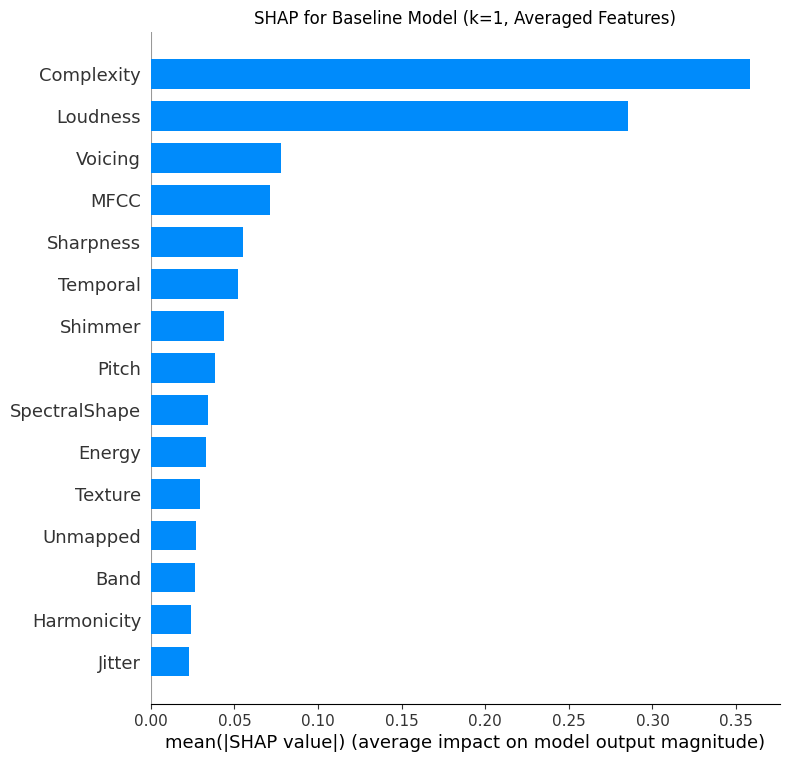

In [16]:
from src.feature_utils.category_descriptor_selection import shap_summary_for_k
import shap
import matplotlib.pyplot as plt

_, baseline_X, _, _, explainer = shap_summary_for_k(
    AGG_aligned, y_valence_mean, hierarchy_map, 
    k=best_k_baseline, 
    aggregation_level='level2' # Corresponds to mean_level2
)

shap.summary_plot(explainer.shap_values(baseline_X), baseline_X, plot_type="bar", show=False)
plt.title(f"SHAP for Baseline Model (k={best_k_baseline}, Averaged Features)")
plt.show()

As shown above, the baseline model using simple averaging is heavily dominated by the 'Loudness' feature. This masks the contribution of other important musical cues, motivating a more sophisticated feature engineering approach.

### Part 2: Keeping all individual low-level features intact inside the parent levels (mid and high level)

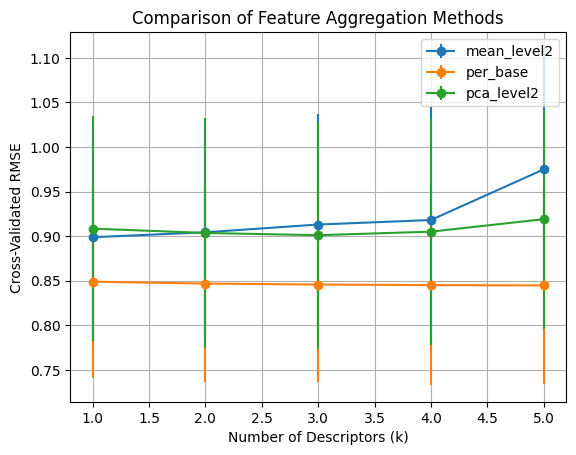

In [17]:
for mode in ['mean_level2', 'per_base', 'pca_level2']:
    df = cv_rmse_across_k(AGG_aligned, y_valence_mean, hierarchy_map, ks=range(1, 6),method='rf', aggregation_mode=mode)
    plt.errorbar(df.k, df.rmse_mean, yerr=df.rmse_std, fmt='-o', label=mode)

plt.legend()
plt.title("Comparison of Feature Aggregation Methods")
plt.xlabel("Number of Descriptors (k)")
plt.ylabel("Cross-Validated RMSE")
plt.grid(True)
plt.show()

It appears that the superior method for performance across different k values is not to aggregate and dilute features, so per-base is the winner with 5-fold validation

### Part 3:Weighing the labels according to their stds

In [18]:
from src.feature_utils.category_descriptor_selection import cv_rmse_across_k_weighted

# Run the k-sweep for the best method (per_base) with and without weights
df_unweighted = cv_rmse_across_k(AGG_aligned, y_valence_mean, hierarchy_map, ks=range(1, 6),method='rf', aggregation_mode='per_base')
df_weighted = cv_rmse_across_k_weighted(AGG_aligned, y_valence_mean, hierarchy_map, labels, std_col='valence_std',
                                        ks=range(1, 6),method='rf', aggregation_mode='per_base')

In [19]:
# Find the final, best k from the unweighted results
best_k_unweighted = pick_best_k(df_unweighted)
print(f"Final optimal k (from unweighted results): {best_k_unweighted}")

Final optimal k (from unweighted results): 5


In [20]:
# Find the final, best k from the weighted results
best_k_final = pick_best_k(df_weighted)
print(f"Final optimal k (from weighted results): {best_k_final}")

Final optimal k (from weighted results): 5


### Part 4: Balanced SHAP results

In [21]:
from src.feature_utils.category_descriptor_selection import select_top_k_descriptors_per_category
# get selections for the optimal k
selections = select_top_k_descriptors_per_category(AGG_aligned, y_valence_mean, hierarchy_map, k=best_k_final, method='rf')

Selecting top-5 descriptors for each category
Available descriptors: ['kurtosis', 'max', 'mean', 'min', 'q25', 'q75', 'skew', 'std']
Evaluation method: rf
------------------------------------------------------------

Dynamics (12 base features):
  kurtosis: 0.4560
  max: 0.4560
  mean: 0.4926
  min: 0.4530
  q25: 0.5059
  q75: 0.4847
  skew: 0.4445
  std: 0.4498
  → Selected: ['q25', 'mean', 'q75', 'kurtosis', 'max']

Harmony (12 base features):
  kurtosis: 0.4386
  max: 0.4435
  mean: 0.4484
  min: 0.4599
  q25: 0.4533
  q75: 0.4631
  skew: 0.4605
  std: 0.4475
  → Selected: ['q75', 'skew', 'min', 'q25', 'mean']

Other (108 base features):
  kurtosis: 0.4578
  max: 0.4618
  mean: 0.4457
  min: 0.4582
  q25: 0.4439
  q75: 0.4480
  skew: 0.4570
  std: 0.4472
  → Selected: ['max', 'min', 'kurtosis', 'skew', 'q75']

Prosodic/Voice (16 base features):
  kurtosis: 0.4512
  max: 0.4613
  mean: 0.4584
  min: 0.4463
  q25: 0.4504
  q75: 0.4528
  skew: 0.4481
  std: 0.4454
  → Selected: ['max',

In [22]:
from src.feature_utils.category_descriptor_selection import build_per_base_X
# Build final feature set
X_final = build_per_base_X(AGG_aligned, hierarchy_map, selections).fillna(0)
y_final = y_valence_mean.loc[X_final.index]

In [23]:
from src.feature_utils.category_descriptor_selection import make_sample_weights
# Create the weights
weights = make_sample_weights(labels, X_final.index, std_col='valence_std')

In [25]:
from sklearn.ensemble import RandomForestRegressor
# Train the final model with weights
final_model = RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1)
final_model.fit(X_final, y_final, sample_weight=weights)

RandomForestRegressor(n_estimators=500, n_jobs=-1, random_state=42)

### Part 5: Proving loudness dominance from base method is an artifact

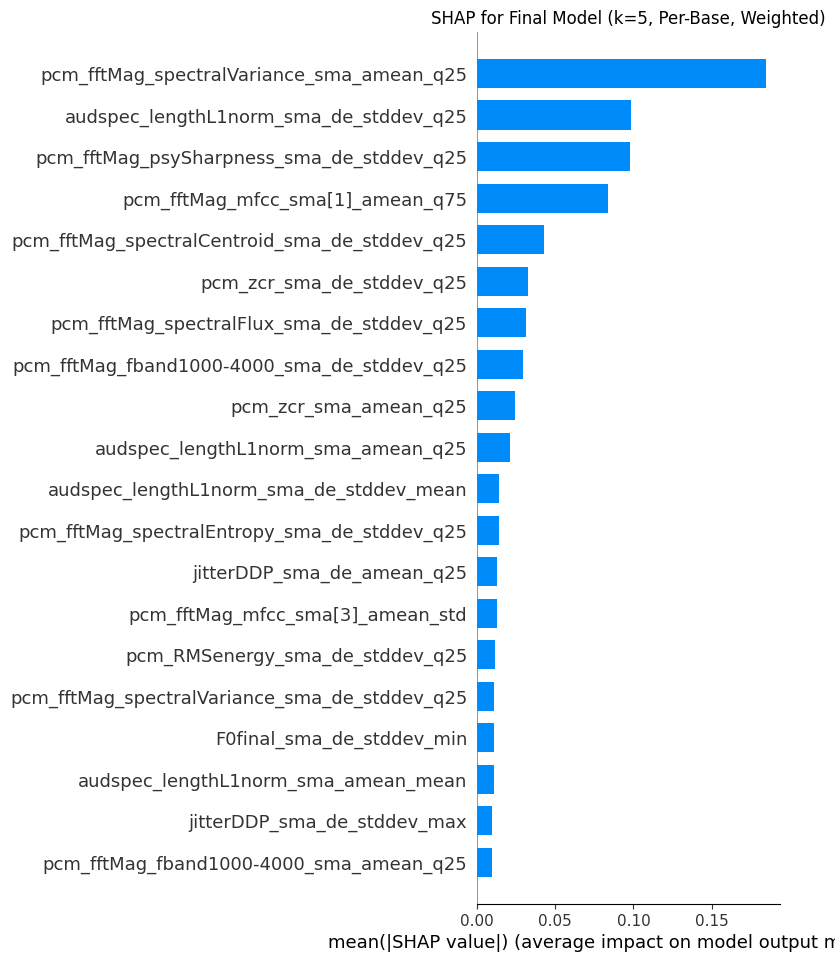

In [26]:
import shap
# Run SHAP for the final, balanced feature importances
sample_X = X_final.sample(min(800, len(X_final)), random_state=42)
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(sample_X)
shap.summary_plot(shap_values, sample_X, plot_type="bar", show=False)
plt.title(f"SHAP for Final Model (k={best_k_final}, Per-Base, Weighted)")
plt.show()

- This shows pure importance of features before grouping them in their respective categories.
- The top feature pcm_fftMag_spectralVariance_sma_amean_q25 represents the 25th percentile of the smoothed spectral variance. This captures the lower range of spectral complexity variations, which correlates with emotional valence - songs with consistent low spectral variance (less timbral variation) tend to be perceived differently emotionally than those with high variance.

In [3]:
#import importlib
#from src.feature_utils import category_descriptor_selection # 1. Import the module

#importlib.reload(category_descriptor_selection) # 2. Reload the module
#from src.feature_utils.category_descriptor_selection import shap_summary_for_k

In [27]:
# 1. Averaged method (original)
rf_avg, X_avg, shap_avg, order_avg, exp_avg = shap_summary_for_k(
    AGG_aligned, y_valence_mean, hierarchy_map, 
    k=3, method = 'rf', mode='level2'
)

# 2. Per-base method with grouped SHAP
rf_per, X_per, shap_per, order_per, exp_per, grouped_shap = shap_summary_for_k(
    AGG_aligned, y_valence_mean, hierarchy_map,
    k=3, method = 'rf',mode='per_base'
)

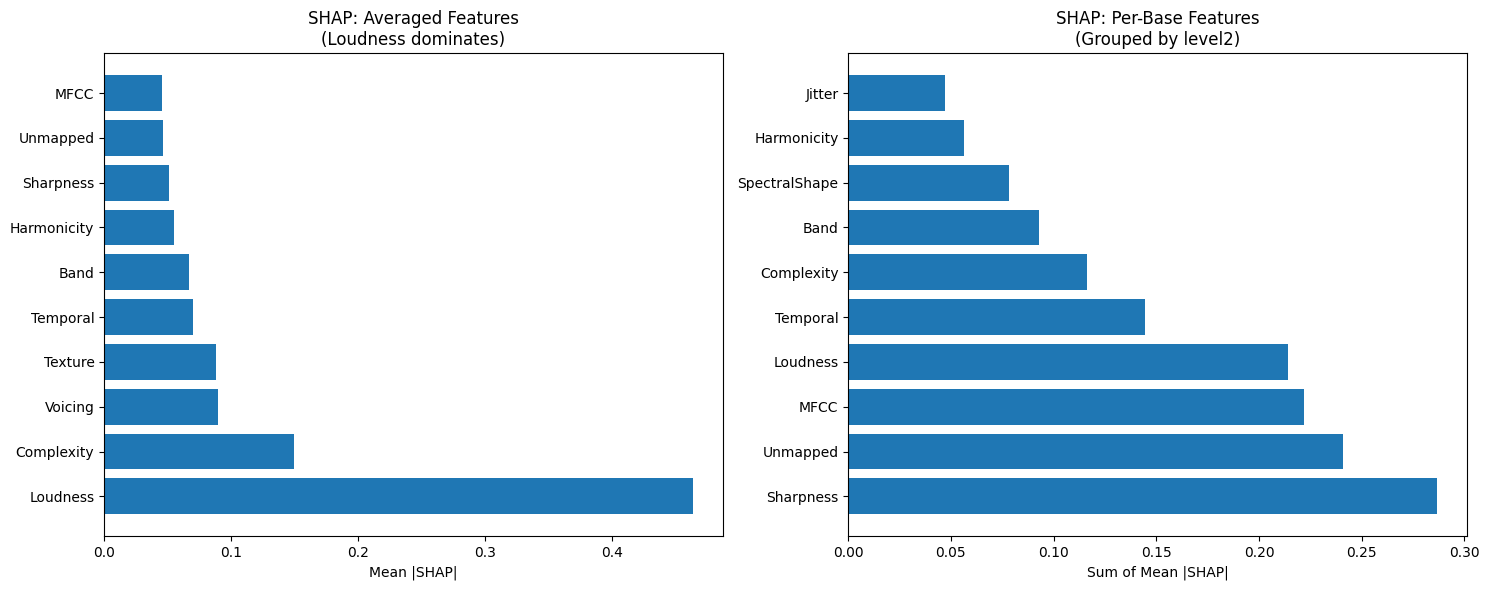

In [28]:
# Compare the two
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Averaged features SHAP
top_features_avg = X_avg.columns[order_avg[:10]]
ax1.barh(range(10), shap_avg[order_avg[:10]])
ax1.set_yticks(range(10))
ax1.set_yticklabels(top_features_avg)
ax1.set_title('SHAP: Averaged Features\n(Loudness dominates)')
ax1.set_xlabel('Mean |SHAP|')

# Plot 2: Per-base grouped SHAP
ax2.barh(range(len(grouped_shap[:10])), grouped_shap[:10].values)
ax2.set_yticks(range(len(grouped_shap[:10])))
ax2.set_yticklabels(grouped_shap[:10].index)
ax2.set_title('SHAP: Per-Base Features\n(Grouped by level2)')
ax2.set_xlabel('Sum of Mean |SHAP|')

plt.tight_layout()
plt.show()

Key notes:
- With k = 3 more features get diluted, and only the signal from loudness remains clear, so it dominates in the averaged method
- In previous graph for SHAP on baseline method with k=1 the main point was still the same, just with complexity up there as well
- The method of preserving every low-level feature without averaging shows more equally distributed importance of features which can lead to far better interpretability when trying to find importance of features, for granularity and XAI on the music theory level. 

In [29]:
print("\nTop groups (averaged method):")
for i in range(min(5, len(order_avg))):
    print(f"  {X_avg.columns[order_avg[i]]}: {shap_avg[order_avg[i]]:.4f}")

print("\nTop groups (per-base grouped):")
for group, importance in grouped_shap[:5].items():
    print(f"  {group}: {importance:.4f}")


Top groups (averaged method):
  Loudness: 0.4635
  Complexity: 0.1494
  Voicing: 0.0897
  Texture: 0.0883
  Temporal: 0.0697

Top groups (per-base grouped):
  Sharpness: 0.2868
  Unmapped: 0.2408
  MFCC: 0.2220
  Loudness: 0.2142
  Temporal: 0.1444



Detailed SHAP values showing how feature values affect predictions:


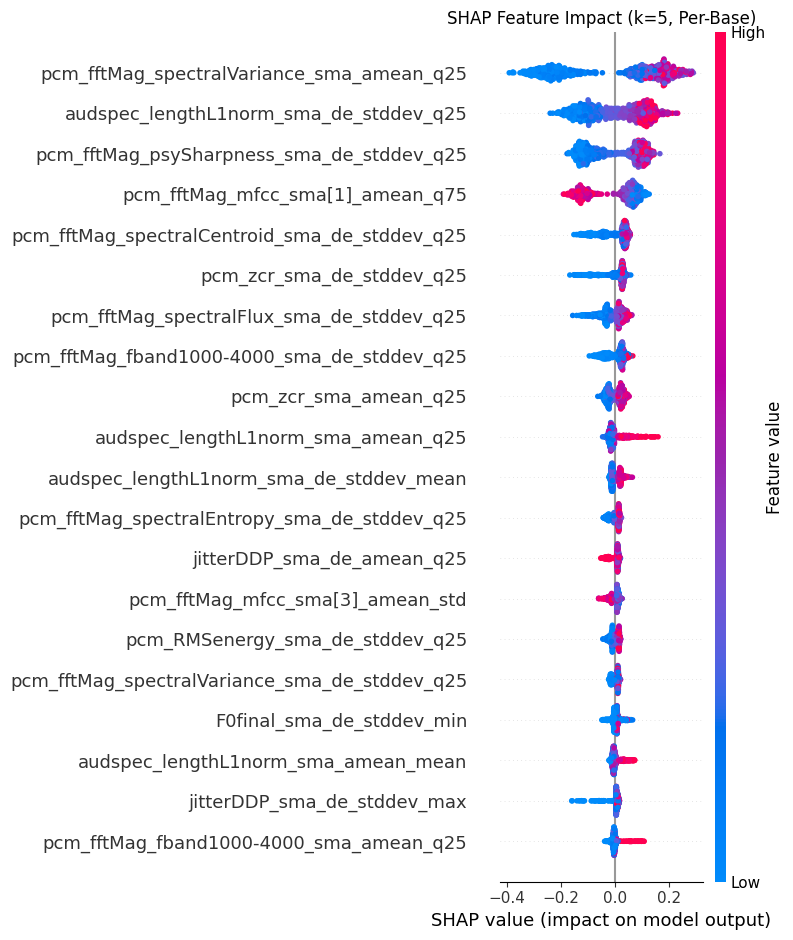

In [30]:
# detailed SHAP visualization
print("\nDetailed SHAP values showing how feature values affect predictions:")
shap.summary_plot(shap_values, sample_X, show=False)
plt.title(f"SHAP Feature Impact (k={best_k_final}, Per-Base)")
plt.tight_layout()
plt.show()

This plot reveals how different feature values impact valence predictions:
- Red/blue dots show high/low feature values
- Position on x-axis shows impact on model output
- Features are ordered by overall importance
- The spread shows how consistently each feature contributes

### Part 6: comparing performance from both methods

In [32]:
from sklearn.model_selection import cross_val_score
# Method 1: Averaged with its best k (k=1)
_, baseline_X_k1, _, _, _ = shap_summary_for_k(
    AGG_aligned, y_valence_mean, hierarchy_map, 
    k=1,  # Averaged method's optimal k
    method='rf',
    mode='level2'
)

# Method 2: Per-base with its best k (k=3)
# X_final calculated in part 4

baseline_scores = -cross_val_score(
    RandomForestRegressor(n_estimators=100, random_state=42),
    baseline_X_k1, y_valence_mean.loc[baseline_X_k1.index],
    cv=5, scoring='neg_root_mean_squared_error'
)

per_base_scores = -cross_val_score(
    RandomForestRegressor(n_estimators=100, random_state=42),
    X_final, y_valence_mean.loc[X_final.index],
    cv=5, scoring='neg_root_mean_squared_error'
)

print(f"\nMethod Comparison (each at their optimal k, unweighted):")
print(f"Averaged (k=1): RMSE = {baseline_scores.mean():.4f} ± {baseline_scores.std():.4f}")
print(f"Per-base (k=3): RMSE = {per_base_scores.mean():.4f} ± {per_base_scores.std():.4f}")
print(f"Improvement: {(baseline_scores.mean() - per_base_scores.mean())/baseline_scores.mean()*100:.1f}%")


Method Comparison (each at their optimal k, unweighted):
Averaged (k=1): RMSE = 0.9055 ± 0.1184
Per-base (k=3): RMSE = 0.8481 ± 0.1111
Improvement: 6.3%


In [33]:
# Both at k=3 to show that even with more features, per-base is better
_, baseline_X_k3, _, _, _ = shap_summary_for_k(
    AGG_aligned, y_valence_mean, hierarchy_map, 
    k=3,  # Same k
    method='rf',
    mode='level2'
)

baseline_scores = -cross_val_score(
    RandomForestRegressor(n_estimators=100, random_state=42),
    baseline_X_k3, y_valence_mean.loc[baseline_X_k1.index],
    cv=5, scoring='neg_root_mean_squared_error'
)

print(f"\nMethod Comparison (both at k=3, unweighted):")
print(f"Improvement: {(baseline_scores.mean() - per_base_scores.mean())/baseline_scores.mean()*100:.1f}%")


Method Comparison (both at k=3, unweighted):
Improvement: 7.3%


Key Insights:
- The averaged method achieves reasonable performance with just k=1, but this is because 
  it collapses everything into the Loudness feature (as shown in SHAP analysis).
- While this creates a simple baseline, it sacrifices interpretability and feature diversity.
- The per-base method (k=3) achieves 6-7% better performance while maintaining feature 
  granularity, enabling true explainable AI for emotion recognition.
- This granular approach preserves individual feature contributions, essential for 
  competing with deep learning while maintaining full interpretability.

### Part 7: Impact of sample weighing on best method

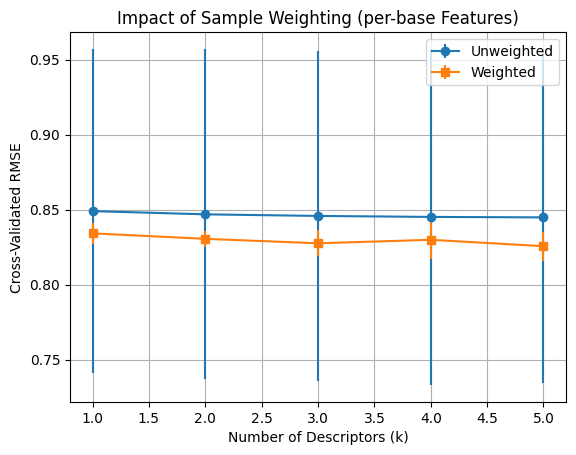

In [34]:
# Get unweighted results for comparison
df_unweighted = cv_rmse_across_k(
    AGG_aligned, y_valence_mean, hierarchy_map, 
    ks=range(1, 6), method='rf', aggregation_mode='per_base'
)

In [35]:
from src.feature_utils.category_descriptor_selection import rmse_cv_with_weights

# Without weights
unweighted_scores = -cross_val_score(
    RandomForestRegressor(n_estimators=100, random_state=42),
    X_final, y_valence_mean.loc[X_final.index],
    cv=5, scoring='neg_root_mean_squared_error'
)

# With weights
weighted_model = RandomForestRegressor(n_estimators=100, random_state=42)
weighted_scores = rmse_cv_with_weights(
    weighted_model,
    X_final, y_valence_mean.loc[X_final.index],
    sample_weight=weights,
    cv=5
)

print(f"\nWeighting Impact (per-base method, k={best_k_final}):")
print(f"Unweighted: RMSE = {unweighted_scores.mean():.4f} ± {unweighted_scores.std():.4f}")
print(f"Weighted:   RMSE = {weighted_scores.mean():.4f} ± {weighted_scores.std():.4f}")
improvement = (unweighted_scores.mean() - weighted_scores.mean())/unweighted_scores.mean()*100
print(f'{improvement:.1f}% improvement')


Weighting Impact (per-base method, k=5):
Unweighted: RMSE = 0.8481 ± 0.1111
Weighted:   RMSE = 0.8285 ± 0.0092
2.3% improvement


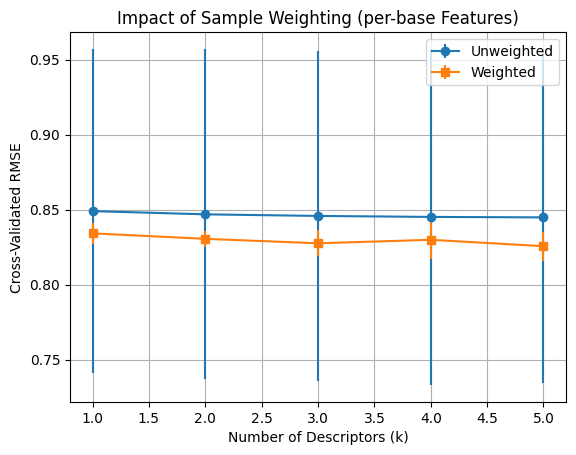

In [36]:
# Plot them together for a direct comparison
plt.errorbar(df_unweighted.k, df_unweighted.rmse_mean, yerr=df_unweighted.rmse_std, fmt='-o', label='Unweighted')
plt.errorbar(df_weighted.k, df_weighted.rmse_mean, yerr=df_weighted.rmse_std, fmt='-s', label='Weighted')

plt.legend()
plt.title("Impact of Sample Weighting (per-base Features)")
plt.xlabel("Number of Descriptors (k)")
plt.ylabel("Cross-Validated RMSE")
plt.grid(True)
plt.show()

Sample weighting accounts for annotation reliability, giving more importance to 
songs with consistent ratings (lower std) during training.

### Save optimal configuration

In [37]:
import json

optimal_config = {
    'best_k': int(best_k_final),
    'method': 'rf',
    'aggregation': 'per_base',
    'weighted': True,
    'selections': selections
}

with open('optimal_descriptor_config.json', 'w') as f:
    json.dump(optimal_config, f, indent=2)

print(f"\nOptimal configuration saved to 'optimal_descriptor_config.json'")


Optimal configuration saved to 'optimal_descriptor_config.json'


# Visualise final category selections

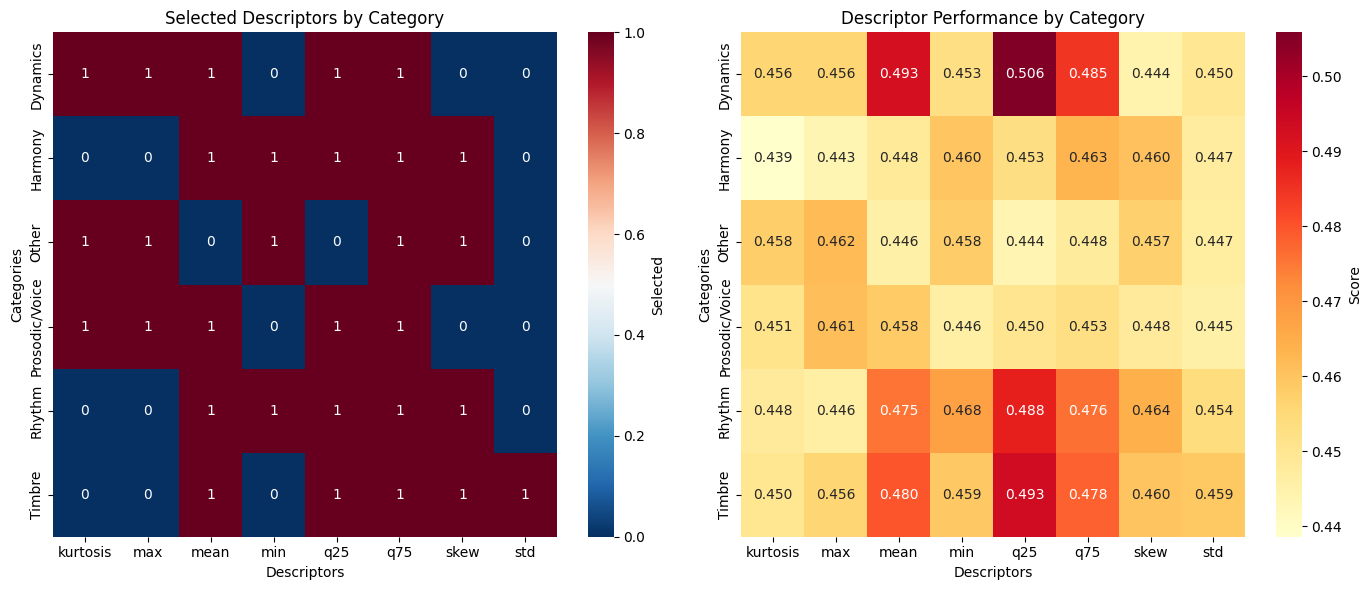

In [38]:
from src.feature_utils.category_descriptor_selection import visualize_category_selections

# Show what descriptors were selected for each category
selection_matrix, performance_matrix = visualize_category_selections(
    selections, AGG_aligned, y_valence_mean, hierarchy_map
)

# Create the mid and high-level features

In [40]:
from src.feature_utils.category_descriptor_selection import create_level2_features
# Create mid-level features from your selected per-base features
mid_level_df = create_level2_features(X_final, hierarchy_map)
print(f"Mid-level features shape: {mid_level_df.shape}")
print(f"Mid-level features: {mid_level_df.columns.tolist()}")

Mid-level features shape: (1802, 15)
Mid-level features: ['Loudness', 'Energy', 'Pitch', 'Harmonicity', 'Unmapped', 'Jitter', 'Shimmer', 'Voicing', 'Temporal', 'Band', 'MFCC', 'Sharpness', 'SpectralShape', 'Complexity', 'Texture']


In [41]:
# Create high-level features
from src.feature_utils.high_level import to_high_level
high_level_df = to_high_level(mid_level_df)
print(f"High-level features shape: {high_level_df.shape}")

High-level features shape: (1802, 5)


# Add music theory features (bpm, key/mode)

In [42]:
from src.feature_utils.music_theory import estimate_bpm, canonical_bpm, estimate_key_mode_confidence

# Add to high-level features
high_level_df['bpm'] = np.nan
high_level_df['key'] = None
high_level_df['mode'] = None
high_level_df['key_confidence'] = np.nan

audio_dir = Path("../data/raw/audio_files_DEAM/MEMD_audio")

In [ ]:
for song_id in tqdm(high_level_df.index, desc="Extracting music theory features"):
    audio_file = audio_dir / f"{song_id}.mp3"
    if audio_file.exists():
        # BPM
        try:
            raw_bpm = estimate_bpm(audio_file)
            high_level_df.loc[song_id, 'bpm'] = canonical_bpm(raw_bpm)
        except:
            pass
        
        # Key and mode
        try:
            key, mode, confidence = estimate_key_mode_confidence(audio_file)
            high_level_df.loc[song_id, 'key'] = key
            high_level_df.loc[song_id, 'mode'] = mode
            high_level_df.loc[song_id, 'key_confidence'] = confidence
        except:
            pass

print(f"Added BPM for {high_level_df['bpm'].notna().sum()} songs")
print(f"Added key for {high_level_df['key'].notna().sum()} songs")

Extracting music theory features:   3%|█▎                                             | 50/1802 [00:44<25:15,  1.16it/s]

# Train/val/test split

In [ ]:
from src.feature_utils.split_data import split_train_val_test_both_targets

# Prepare for splitting
X_high = high_level_df.select_dtypes(include=[np.number])  # Only numeric for modeling

train_ids, val_ids, test_ids = split_train_val_test_both_targets(
    X=X_high,
    y_valence=y_valence_mean,
    y_arousal=y_arousal_mean,
    labels_df=labels,
    test_song_id_start=2001,
    val_size=0.15,
    stratify_both=True
)

# Normalize features

In [ ]:
from src.feature_utils.normalization import SplitScaler

# Split the data
X_train = X_high.loc[train_ids]
X_val = X_high.loc[val_ids]
X_test = X_high.loc[test_ids] if len(test_ids) > 0 else pd.DataFrame()

In [ ]:
# Normalize
scaler = SplitScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test) if len(test_ids) > 0 else pd.DataFrame()

print(f"Train: {X_train_scaled.shape}")
print(f"Val: {X_val_scaled.shape}")
print(f"Test: {X_test_scaled.shape if len(test_ids) > 0 else 'No test set'}")

Note: Normalization at this stage after having already used the unscaled features throughout is fine. The reason is because the methods that were used to find optimal k descriptors per each low-level feature were scale agnostic (rf), but future distance based methods (like KNN) will require a more scaled feature space

# Save everything

In [ ]:
import joblib

output_dir = Path("final_features_optimized")
output_dir.mkdir(exist_ok=True)

# Save feature sets at different levels
X_final.to_parquet(output_dir / "low_level_selected.parquet")
mid_level_df.to_parquet(output_dir / "mid_level.parquet")
high_level_df.to_parquet(output_dir / "high_level.parquet")

# Save splits
X_train_scaled.to_parquet(output_dir / "X_train_scaled.parquet")
X_val_scaled.to_parquet(output_dir / "X_val_scaled.parquet")
if len(test_ids) > 0:
    X_test_scaled.to_parquet(output_dir / "X_test_scaled.parquet")

# Save targets
y_valence_mean.loc[train_ids].to_csv(output_dir / "y_valence_train.csv")
y_valence_mean.loc[val_ids].to_csv(output_dir / "y_valence_val.csv")
if len(test_ids) > 0:
    y_valence_mean.loc[test_ids].to_csv(output_dir / "y_valence_test.csv")

y_arousal_mean.loc[train_ids].to_csv(output_dir / "y_arousal_train.csv")
y_arousal_mean.loc[val_ids].to_csv(output_dir / "y_arousal_val.csv")
if len(test_ids) > 0:
    y_arousal_mean.loc[test_ids].to_csv(output_dir / "y_arousal_test.csv")

# Save scaler and config
joblib.dump(scaler, output_dir / "scaler.pkl")

print(f"\nAll features saved to {output_dir}/")
print(f"  Low-level (selected): {X_final.shape}")
print(f"  Mid-level: {mid_level_df.shape}")
print(f"  High-level: {high_level_df.shape}")

/tmp/ipykernel_488/2175927479.py:1: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([perm[1], perm[3]], labels=["k=1","k=3"])


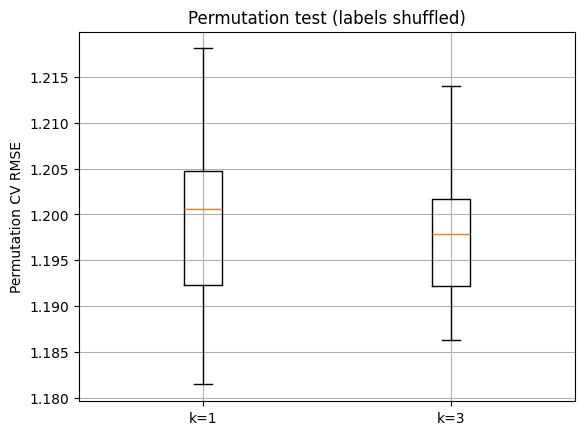

In [27]:
plt.boxplot([perm[1], perm[3]], labels=["k=1","k=3"])
plt.ylabel("Permutation CV RMSE")
plt.title("Permutation test (labels shuffled)")
plt.grid(True)
plt.show()

In [29]:
from src.feature_utils.category_descriptor_selection import model_family_rmse_across_k

res_models = model_family_rmse_across_k(AGG_aligned, y_valence_mean, hierarchy_map, ks=range(1,9), aggregation_level='level2')

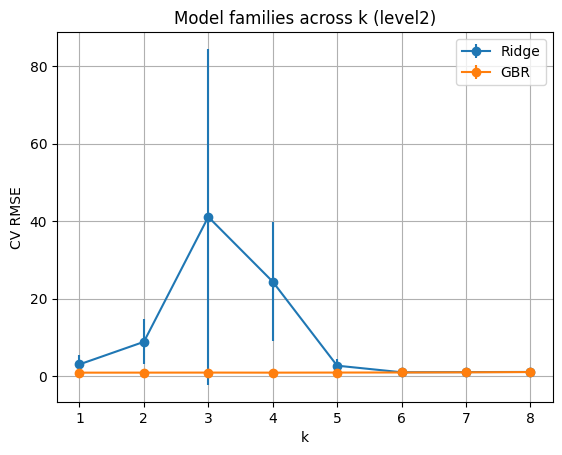

In [30]:
for name, df in res_models.items():
    plt.errorbar(df.k, df.rmse_mean, yerr=df.rmse_std, fmt='-o', label=name)
plt.legend()
plt.xlabel("k")
plt.ylabel("CV RMSE")
plt.title("Model families across k (level2)")
plt.grid(True)
plt.show()

In [20]:
comparison_df = pd.DataFrame(results_comparison).T
print("\n", comparison_df.to_string())

# Select best method based on validation RMSE
best_method = comparison_df['val_rmse'].idxmin()
best_k = int(comparison_df.loc[best_method, 'optimal_k'])
best_rmse = comparison_df.loc[best_method, 'val_rmse']


              optimal_k  val_rmse  train_rmse  overfitting_gap  total_features
correlation        1.0  0.864254    0.327434         0.536819           260.0
rf                 1.0  0.872632    0.333482         0.539150           260.0


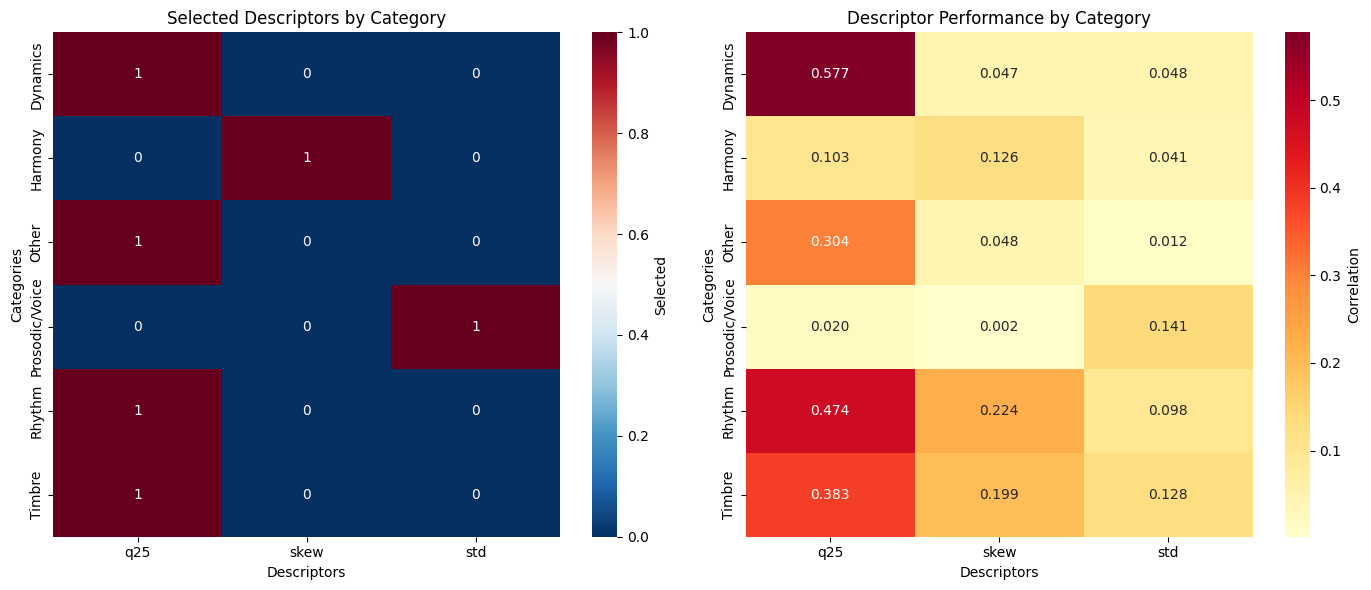

(                q25  skew  std
 Dynamics          1     0    0
 Harmony           0     1    0
 Other             1     0    0
 Prosodic/Voice    0     0    1
 Rhythm            1     0    0
 Timbre            1     0    0,
                      q25      skew       std
 Dynamics        0.577261  0.046872  0.048483
 Harmony         0.103292  0.126278  0.041234
 Other           0.303583  0.047842  0.012179
 Prosodic/Voice   0.02028  0.001706  0.140893
 Rhythm          0.474469   0.22394  0.097903
 Timbre          0.383121  0.199357  0.128468)

In [22]:
from src.feature_utils.category_descriptor_selection import visualize_category_selections

# shows heatmaps and summary plots
visualize_category_selections(
    category_selections=selections,
    agg_df=AGG_aligned,
    y=y_valence_mean,
    hierarchy_map=hierarchy_map
)

In [39]:
from src.feature_utils.category_descriptor_selection import create_features_with_category_selections

# create the dataframes
low_level_df, mid_level_df,_ = create_features_with_category_selections(
        agg_df=AGG_aligned, hierarchy_map=hierarchy_map, category_selections=selections, aggregation_level='level2'
    )
print("Final Mid-Level Features:")
display(mid_level_df.head())

Final Mid-Level Features:


,Loudness,Energy,Pitch,Harmonicity,Unmapped,Jitter,Shimmer,Voicing,Temporal,Band_MidHigh,Band_LowMid,MFCC_Texture,MFCC_Formant,MFCC_Spectral,Sharpness,SpectralShape,Complexity,Texture
10,5.861429,0.036293,28.523027,14.266106,9.578466,0.018626,0.029535,0.081212,0.065057,0.324065,0.310003,8.146313,10.447552,6.716350,0.192756,301.558276,318974.141942,438.337202
1000,1.265044,0.095052,46.485350,23.305425,2.554603,0.021063,0.024488,0.074233,0.233982,1.680212,1.985101,4.814690,5.728322,5.204883,0.244993,407.353714,621041.457529,12.231645
1001,0.563227,0.029914,16.535759,6.717220,0.511155,0.026946,0.037488,0.127681,0.094476,0.252719,0.338563,4.157815,5.732778,4.990323,0.219655,352.877814,524392.773212,9.134155
1002,0.828860,0.058947,11.667560,13.196886,1.022248,0.024970,0.047150,0.129800,0.059672,0.477568,0.819327,6.085886,12.778508,10.791746,0.170752,267.121152,255581.479588,1118.534395
1003,0.989964,0.047579,12.797657,4.042839,1.064485,0.021751,0.042839,0.142120,0.066520,0.334283,1.111038,6.586389,8.750835,6.863276,0.255223,403.419783,345954.377142,444.487028


### Create high-level features

In [40]:
from src.feature_utils.high_level import to_high_level

# Create the final high-level features
high_level_df = to_high_level(mid_level_df)

print("Final High-Level Features:")
display(high_level_df.head())

Final High-Level Features:


,pitch_consistency,vocal_quality,timbre_complexity,energy_level,rhythmic_intensity,tonal_balance
10,14.302120,4.771423,45677.077199,2.948861,0.065057,0.014063
1000,23.279791,7.783659,88782.433682,0.680048,0.233982,-0.304889
1001,8.331720,2.260551,74967.126536,0.296570,0.094476,-0.085844
1002,5.898680,4.423002,36713.851718,0.443903,0.059672,-0.341759
1003,6.469889,1.369143,49546.391382,0.518771,0.066520,-0.776755


### Add music theory features

In [42]:
from pathlib import Path
from tqdm import tqdm
import numpy as np
import pandas as pd
from src.feature_utils.music_theory import estimate_bpm, canonical_bpm, estimate_key_mode_confidence

# Initialize columns
high_level_df['bpm'] = np.nan
high_level_df['key'] = None
high_level_df['mode'] = None
high_level_df['key_confidence'] = np.nan

# Add BPM and Key estimation
audio_dir = Path("../data/raw/audio_files_DEAM/MEMD_audio")

bpm_results = {}
key_results = {}

for song_id in tqdm(high_level_df.index, desc="Processing audio features"):
    audio_file = audio_dir / f"{song_id}.mp3"
    
    if audio_file.exists():
        # BPM
        try:
            raw_bpm = estimate_bpm(str(audio_file))
            bpm_results[song_id] = canonical_bpm(raw_bpm)
        except:
            bpm_results[song_id] = np.nan
        
        # Key and mode
        try:
            key, mode, confidence = estimate_key_mode_confidence(str(audio_file))
            key_results[song_id] = {'key': key, 'mode': mode, 'key_confidence': confidence}
        except:
            key_results[song_id] = {'key': None, 'mode': None, 'key_confidence': np.nan}
    else:
        bpm_results[song_id] = np.nan
        key_results[song_id] = {'key': None, 'mode': None, 'key_confidence': np.nan}

# Add to dataframe
for song_id in high_level_df.index:
    if song_id in bpm_results:
        high_level_df.loc[song_id, 'bpm'] = bpm_results[song_id]
    
    if song_id in key_results:
        high_level_df.loc[song_id, 'key'] = key_results[song_id]['key']
        high_level_df.loc[song_id, 'mode'] = key_results[song_id]['mode']
        high_level_df.loc[song_id, 'key_confidence'] = key_results[song_id]['key_confidence']

print(f"Added BPM for {high_level_df['bpm'].notna().sum()} songs")
print(f"Added key for {high_level_df['key'].notna().sum()} songs")

Processing audio features: 100%|████████████████████████████████████████████████████| 1545/1545 [22:04<00:00,  1.17it/s]


Added BPM for 1545 songs
Added key for 1545 songs


In [43]:
print("High-level DataFrame shape:", high_level_df.shape)
print("High-level columns:", list(high_level_df.columns))
print("\nFirst few rows with new features:")
if 'bpm' in high_level_df.columns:
    print(high_level_df[['bpm', 'key', 'mode', 'key_confidence']].head())
    print(f"\nBPM values found: {high_level_df['bpm'].notna().sum()}")
    print(f"Key values found: {high_level_df['key'].notna().sum()}")

High-level DataFrame shape: (1545, 10)
High-level columns: ['pitch_consistency', 'vocal_quality', 'timbre_complexity', 'energy_level', 'rhythmic_intensity', 'tonal_balance', 'bpm', 'key', 'mode', 'key_confidence']

First few rows with new features:
         bpm key   mode  key_confidence
10     95.70   D  major        0.461026
1000  136.00   A  minor        0.749580
1001  117.45   A  major        0.742423
1002  143.55   C  major        0.235218
1003   89.10   A  minor        0.326619

BPM values found: 1545
Key values found: 1545


### Train/val/test split and normalization

In [51]:
# Debug: Track test songs through the pipeline

print("=== TRACKING TEST SONGS THROUGH PIPELINE ===\n")

# 1. Check AGG (raw features)
print(f"1. AGG shape: {AGG.shape}")
print(f"   AGG index range: {AGG.index.min()} - {AGG.index.max()}")
print(f"   Test songs (>2000): {(AGG.index > 2000).sum()}")

# 2. Check labels
labels = pd.read_parquet("../data/processed/DEAM/deam_core_with_lyrics.parquet")
labels = labels.set_index('song_id')
print(f"\n2. Labels shape: {labels.shape}")
print(f"   Labels index range: {labels.index.min()} - {labels.index.max()}")
print(f"   Test songs (>2000): {(labels.index > 2000).sum()}")

# 3. Check y_valence_mean (used for alignment)
y_valence_mean = labels['valence_mean']
print(f"\n3. y_valence_mean length: {len(y_valence_mean)}")
print(f"   y_valence_mean index range: {y_valence_mean.index.min()} - {y_valence_mean.index.max()}")
print(f"   Test songs (>2000): {(y_valence_mean.index > 2000).sum()}")

# 4. Check AGG_aligned (after intersection)
common_ids = AGG.index.intersection(y_valence_mean.index)
print(f"\n4. Common IDs: {len(common_ids)}")
print(f"   Common IDs range: {common_ids.min()} - {common_ids.max()}")
print(f"   Test songs in common: {(common_ids > 2000).sum()}")

AGG_aligned = AGG.loc[common_ids]
print(f"   AGG_aligned shape: {AGG_aligned.shape}")
print(f"   Test songs in AGG_aligned: {(AGG_aligned.index > 2000).sum()}")

# 5. Check mid_level_df
print(f"\n5. mid_level_df shape: {mid_level_df.shape}")
print(f"   mid_level_df index range: {mid_level_df.index.min()} - {mid_level_df.index.max()}")
print(f"   Test songs (>2000): {(mid_level_df.index > 2000).sum()}")

# 6. Check high_level_df
print(f"\n6. high_level_df shape: {high_level_df.shape}")
print(f"   high_level_df index range: {high_level_df.index.min()} - {high_level_df.index.max()}")
print(f"   Test songs (>2000): {(high_level_df.index > 2000).sum()}")

# Find where they got lost
if (AGG.index > 2000).sum() > 0 and (AGG_aligned.index > 2000).sum() == 0:
    print("\n❌ TEST SONGS LOST AT: AGG → AGG_aligned alignment step")
elif (AGG_aligned.index > 2000).sum() > 0 and (mid_level_df.index > 2000).sum() == 0:
    print("\n❌ TEST SONGS LOST AT: AGG_aligned → mid_level_df transformation")
elif (mid_level_df.index > 2000).sum() > 0 and (high_level_df.index > 2000).sum() == 0:
    print("\n❌ TEST SONGS LOST AT: mid_level_df → high_level_df transformation")

=== TRACKING TEST SONGS THROUGH PIPELINE ===

1. AGG shape: (1802, 2080)
   AGG index range: 2 - 2058
   Test songs (>2000): 58

2. Labels shape: (1802, 7)
   Labels index range: 2 - 2058
   Test songs (>2000): 58

3. y_valence_mean length: 1802
   y_valence_mean index range: 2 - 2058
   Test songs (>2000): 58

4. Common IDs: 1802
   Common IDs range: 2 - 2058
   Test songs in common: 58
   AGG_aligned shape: (1802, 2080)
   Test songs in AGG_aligned: 58

5. mid_level_df shape: (1545, 18)
   mid_level_df index range: 2 - 1801
   Test songs (>2000): 0

6. high_level_df shape: (1545, 10)
   high_level_df index range: 2 - 1801
   Test songs (>2000): 0

❌ TEST SONGS LOST AT: AGG_aligned → mid_level_df transformation


In [44]:
from src.feature_utils.split_data import split_train_val_test_both_targets

# Load labels with artist information
labels = pd.read_parquet("../data/processed/DEAM/deam_core_with_lyrics.parquet")
labels = labels.set_index('song_id')

In [45]:
# Align features and labels
common_ids = high_level_df.index.intersection(labels.index)
X = high_level_df.loc[common_ids].select_dtypes(include=[np.number])
y_valence = labels.loc[common_ids, 'valence_mean']
y_arousal = labels.loc[common_ids, 'arousal_mean']

print(f"Final dataset shape: {X.shape}")
print(f"Features: {list(X.columns)}")

Final dataset shape: (1545, 8)
Features: ['pitch_consistency', 'vocal_quality', 'timbre_complexity', 'energy_level', 'rhythmic_intensity', 'tonal_balance', 'bpm', 'key_confidence']


In [46]:
train_ids, val_ids, test_ids = split_train_val_test_both_targets(
    X=X,
    y_valence=y_valence,
    y_arousal=y_arousal,
    labels_df=labels.loc[common_ids],  # Pass the aligned labels
    test_song_id_start=2001,
    val_size=0.15,
    stratify_both=True  # Balance both valence and arousal
)

Total songs available: 1545
Test set (song_id >= 2001): 0 songs
Train+Val pool: 1545 songs
Created stratification with 25 combined bins
Selected split with balance score: 0.201
Final split:
  Train: 1295 songs (83.8%)
  Val:   250 songs (16.2%)
  Test:  0 songs (0.0%)

Valence distribution check:
  Train valence mean: 4.891
  Val valence mean:   4.867
  Test valence mean:  nan

Arousal distribution check:
  Train arousal mean: 4.767
  Val arousal mean:   4.734
  Test arousal mean:  nan
No artist leakage between train and val


In [47]:
# Create the splits
X_train = X.loc[train_ids]
X_val = X.loc[val_ids]
X_test = X.loc[test_ids]

y_val_train = y_valence.loc[train_ids]
y_val_val = y_valence.loc[val_ids]
y_val_test = y_valence.loc[test_ids]

y_aro_train = y_arousal.loc[train_ids]
y_aro_val = y_arousal.loc[val_ids]
y_aro_test = y_arousal.loc[test_ids]

In [48]:
# Normalization (fit only on training data)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train), 
    index=X_train.index, 
    columns=X_train.columns
)
X_val_scaled = pd.DataFrame(
    scaler.transform(X_val), 
    index=X_val.index, 
    columns=X_val.columns
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test), 
    index=X_test.index, 
    columns=X_test.columns
)

print(f"\nFinal splits:")
print(f"  Training set: {X_train_scaled.shape}")
print(f"  Validation set: {X_val_scaled.shape}")
print(f"  Test set: {X_test_scaled.shape}")

ValueError: Found array with 0 sample(s) (shape=(0, 8)) while a minimum of 1 is required by StandardScaler.

### Save the datasets

In [ ]:
from pathlib import Path
import joblib

output_dir = Path("final_features_optimized")
output_dir.mkdir(exist_ok=True)

In [ ]:
# Save feature matrices
low_level_df.to_csv(output_dir / "low_level_features_selected.csv")
mid_level_df.to_csv(output_dir / "mid_level_features.csv")
high_level_df.to_csv(output_dir / "high_level_features.csv")

In [ ]:
# Save splits - now including validation set
X_train_scaled.to_csv(output_dir / "X_train_scaled.csv")
X_val_scaled.to_csv(output_dir / "X_val_scaled.csv")
X_test_scaled.to_csv(output_dir / "X_test_scaled.csv")

y_val_train.to_csv(output_dir / "y_valence_train.csv")
y_val_val.to_csv(output_dir / "y_valence_val.csv")
y_val_test.to_csv(output_dir / "y_valence_test.csv")

y_aro_train.to_csv(output_dir / "y_arousal_train.csv")
y_aro_val.to_csv(output_dir / "y_arousal_val.csv")
y_aro_test.to_csv(output_dir / "y_arousal_test.csv")

In [ ]:
# Save scaler and selections
joblib.dump(scaler, output_dir / "scaler.pkl")
import json
with open(output_dir / "category_descriptor_selections.json", 'w') as f:
    json.dump(selections, f, indent=2)

print(f"\nAll data saved to {output_dir}/")

### Model Test

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Train on training set, tune on validation, final eval on test
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_scaled, y_val_train)

In [ ]:
# Validation performance (for hyperparameter tuning)
y_pred_val = model.predict(X_val_scaled)
rmse_val = mean_squared_error(y_val_val, y_pred_val, squared=False)
r2_val = r2_score(y_val_val, y_pred_val)

print(f"\nValidation set performance (Valence):")
print(f"  RMSE: {rmse_val:.4f}")
print(f"  R²: {r2_val:.4f}")

In [ ]:
# Test performance (final evaluation)
y_pred_test = model.predict(X_test_scaled)
rmse_test = mean_squared_error(y_val_test, y_pred_test, squared=False)
r2_test = r2_score(y_val_test, y_pred_test)

print(f"\nTest set performance (Valence):")
print(f"  RMSE: {rmse_test:.4f}")
print(f"  R²: {r2_test:.4f}")

In [ ]:
# Also test arousal
model_aro = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model_aro.fit(X_train_scaled, y_aro_train)

y_pred_aro_test = model_aro.predict(X_test_scaled)
rmse_aro_test = mean_squared_error(y_aro_test, y_pred_aro_test, squared=False)
r2_aro_test = r2_score(y_aro_test, y_pred_aro_test)

print(f"\nTest set performance (Arousal):")
print(f"  RMSE: {rmse_aro_test:.4f}")
print(f"  R²: {r2_aro_test:.4f}")

print("\n" + "="*60)
print("✓ Used artist-aware splitting to prevent leakage")
print("✓ Stratified by both valence and arousal")
print("✓ Predefined test set (song_id >= 2001) for fair evaluation")
print("="*60)